In [2]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

from sklearn.svm import LinearSVC, SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

from utils import draw_bounding_boxes, crop_image_using_labels
from hog import compute_gradients, get_window_descriptor
from sliding_window import sliding_window_detection_multi_scale

In [3]:
X_train = np.load('data/train/features.npy')
y_train = np.load('data/train/labels.npy')

pos_idx = y_train == 1
neg_idx = y_train == 0

print(len(X_train), len(X_train[pos_idx]), len(X_train[neg_idx]))

5144 1294 3850


In [4]:
# Run this if you want to fit linear svm classifier to training data and save it
import pickle

classifier_linear = make_pipeline(StandardScaler(), LinearSVC(max_iter=2000, C=0.1))
classifier_linear.fit(X_train, y_train)

pickle.dump(classifier_linear, open("classifier_linear.pkl", 'wb'))

In [5]:
# Run this if you want to fit rbf svm classifier to training data and save it
import pickle

classifier_rbf = make_pipeline(StandardScaler(), SVC(kernel="rbf", C=0.1))
classifier_rbf.fit(X_train, y_train)

pickle.dump(classifier_rbf, open("classifier_rbf.pkl", 'wb'))

In [6]:
# Run this to load the classifiers
import pickle

classifier_linear = pickle.load(open('classifier_linear.pkl', 'rb'))
classifier_rbf = pickle.load(open('classifier_rbf.pkl', 'rb'))

In [7]:
# Select classifier
classifier = classifier_linear

In [8]:
# Run this to load the validation and testing data
X_valid = np.load('data/valid/features.npy')
y_valid = np.load('data/valid/labels.npy')
pos_idx = y_valid == 1
neg_idx = y_valid == 0
print(len(X_valid), len(X_valid[pos_idx]), len(X_valid[neg_idx]))

X_test = np.load('data/test/features.npy')
y_test = np.load('data/test/labels.npy')
pos_idx = y_test == 1
neg_idx = y_test == 0
print(len(X_test), len(X_test[pos_idx]), len(X_test[neg_idx]))

1410 369 1041
719 174 545


In [9]:
# Predict on the validation set using classifier

y_pred = classifier.predict(X_valid)

# Show the accuracy scores and metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy = accuracy_score(y_valid, y_pred)
precision = precision_score(y_valid, y_pred, average="binary")
recall = recall_score(y_valid, y_pred, average="binary")
f1 = f1_score(y_valid, y_pred, average="binary")

print("Metrics for Validation Data:")
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

Metrics for Validation Data:
Accuracy: 0.96
Precision: 0.90
Recall: 0.96
F1 Score: 0.93


In [10]:
# Predict on the test set using classifier

y_pred = classifier.predict(X_test)

# Show the accuracy scores and metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average="binary")
recall = recall_score(y_test, y_pred, average="binary")
f1 = f1_score(y_test, y_test, average="binary")

print("Metrics for Test Data:")
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

Metrics for Test Data:
Accuracy: 0.97
Precision: 0.90
Recall: 0.97
F1 Score: 1.00


crop_000019_jpg.rf.041b8cac248fe94b39e98e8169841177.jpg
Detecting... 2560 windows processed


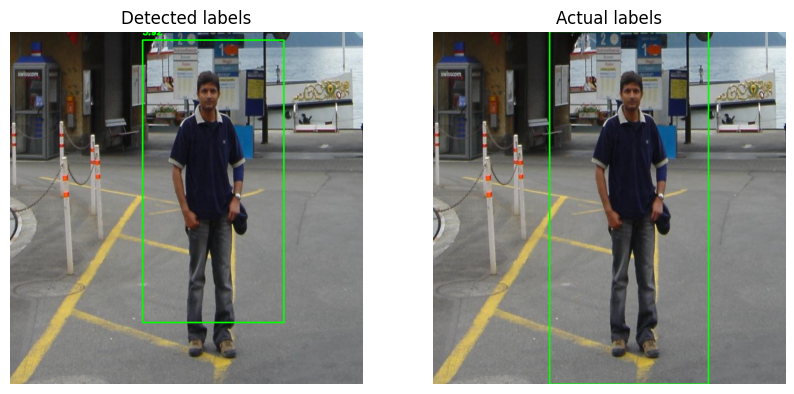

crop001088_jpg.rf.5cf379ddcefb0f5055f40f75ef9245dd.jpg
Detecting... 2560 windows processed


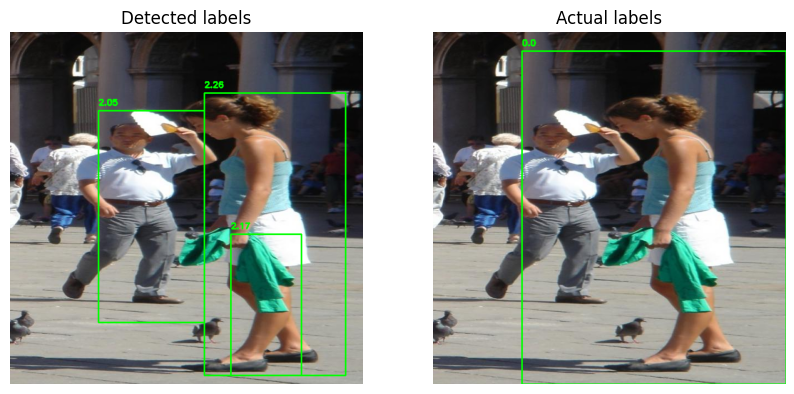

crop001675_jpg.rf.2ab55c5b3721c0f00ee732072c01e1fe.jpg
Detecting... 2560 windows processed


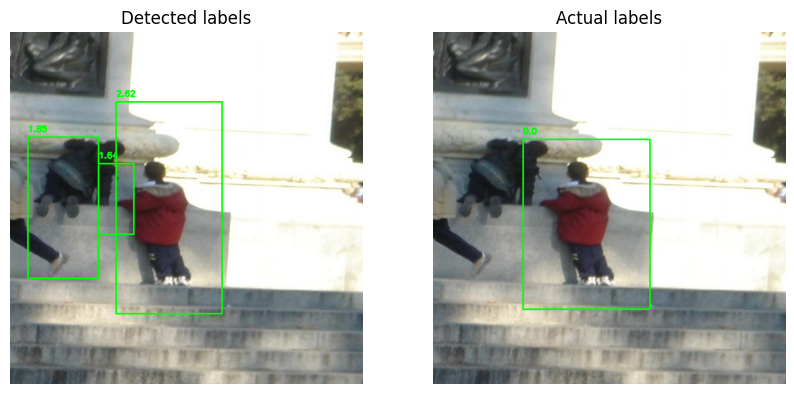

crop001593_jpg.rf.68790217bef91ba41f11aad30433606d.jpg
Detecting... 2560 windows processed


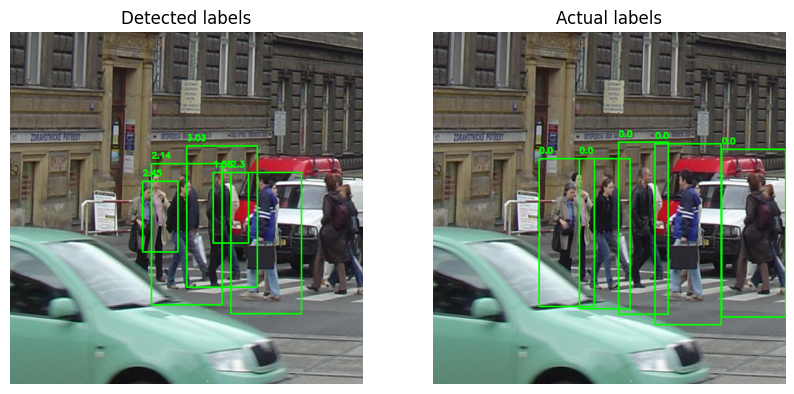

crop001675_jpg.rf.2ab55c5b3721c0f00ee732072c01e1fe.jpg
Detecting... 2560 windows processed


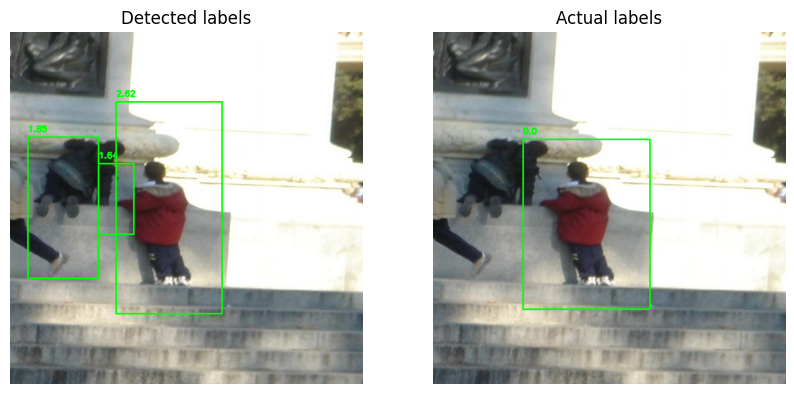

crop001092_jpg.rf.b75a126fc8cf5cc19c234a4aae22d486.jpg
Detecting... 2560 windows processed


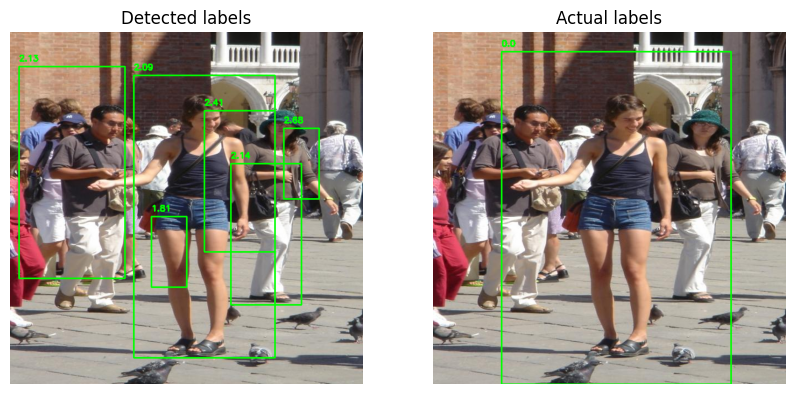

crop001833_jpg.rf.1480809617c94a7180aff49f7a5da46d.jpg
Detecting... 2560 windows processed


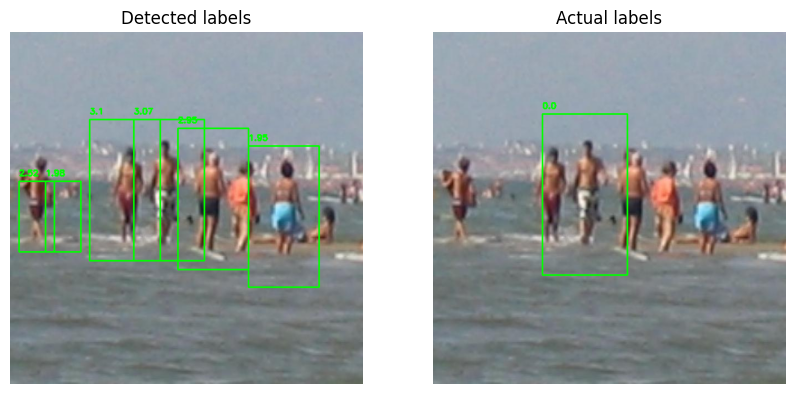

person_239_jpg.rf.86c9567bcb7e4df71247b9d95c0da679.jpg
Detecting... 2560 windows processed


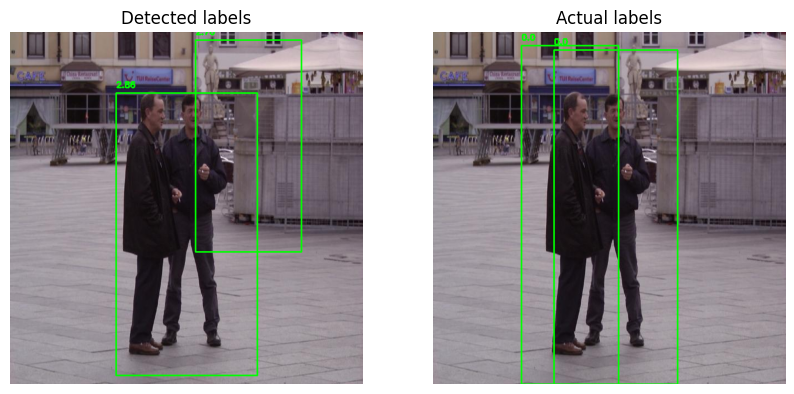

17.6 s ± 350 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [11]:
%%timeit
# Testing sliding window and a classifier on a random image from test data
import random
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

imfile = random.choice(os.listdir("./inria/test/images/"))
print(imfile)
labels = np.loadtxt(f'./inria/test/labels/{imfile[:-4]}.txt', ndmin=2)
img_path = os.path.join("inria/test/images", imfile)

img = cv2.resize(cv2.imread(img_path), (640, 640), interpolation=cv2.INTER_AREA)
img2 = np.copy(img)
img_copy = np.copy(img).astype(np.float64)

print("Detecting...", end=" ")
detected_labels, num_wins_processed = sliding_window_detection_multi_scale(img_copy, classifier, scales=[1.0, 2.0, 3.0, 4.0, 5.0], top_k=10, iou_threshold_nms=0.3)
print(f"{num_wins_processed} windows processed")

if len(detected_labels) == 0:
    print("No human detected")
else:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    draw_bounding_boxes(img, detected_labels)
    draw_bounding_boxes(img2, labels, add_margin=True)
    ax1.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    ax2.imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))
    ax1.set_title('Detected labels')
    ax2.set_title('Actual labels')
    ax1.axis('off')
    ax2.axis('off')
    plt.show()